In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

def fetch(url):
    import pathlib, requests,os, hashlib, numpy, gzip, tempfile
    fp = os.path.join(tempfile.gettempdir(), hashlib.md5(url.encode("utf-8")).hexdigest())
    if(os.path.isfile(fp)):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=numpy.uint8).copy()


#fetch data
X_train = fetch("https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz")
Y_train = fetch("https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz")
X_test = fetch("https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz")
Y_test = fetch("https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz")

#normalize pixel
def preprocess_mnist(data):
    data = data[16:]   
    images = data.reshape(-1, 28, 28) 
    images = images.astype('float32') / 255.0
    
    return images

X_train_normalized = preprocess_mnist(X_train).reshape(-1,784)
X_test_normalized = preprocess_mnist(X_test).reshape(-1,784)


#one-hot encoding
def one_hot_encoding(data):
    data = data[8:]  # Offset zum Entfernen des Headers bei den Label-Daten
    n_labels = len(data)
    one_hot = np.zeros((n_labels, 10), dtype=np.int8)
    
    one_hot[np.arange(n_labels), data] = 1
    
    return one_hot

# Labels für das Training und Testen in One-Hot-Encoding umwandeln
Y_train_one_hot = one_hot_encoding(Y_train)
Y_test_one_hot = one_hot_encoding(Y_test)

In [2]:
#Bad version
class Model:
    def __init__(self, input_size, hidden_size, output_size):
        self.rng = np.random.default_rng()
        
        # Initialisierung der Gewichte mit der layer_init Funktion
        self.w1 = self.layer_init(input_size, hidden_size)
        self.w2 = self.layer_init(hidden_size, hidden_size)
        self.w3 = self.layer_init(hidden_size, output_size)
        
        self.b1 = np.zeros((1, hidden_size), dtype=np.float32)
        self.b2 = np.zeros((1, hidden_size), dtype=np.float32)
        self.b3 = np.zeros((1, output_size), dtype=np.float32)

 
    def layer_init(self, m, h):
        return np.random.uniform(-1., 1., size=(m, h)) / np.sqrt(m * h)



    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    def forward(self, x):
        self.z1 = np.dot(x,self.w1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.relu(self.z2)
        self.z3 = np.dot(self.a2, self.w3) + self.b3
        output = self.softmax(self.z3)
        return output

    @staticmethod
    def softmax(x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp/np.sum(exp, axis=1, keepdims=True)

    def backward(self, x, y, output):
        m = y.shape[0]
        dz3 = output - y
        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m
        dz2 = np.dot(dz3, self.w3.T) * (self.z2 > 0)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.w2.T) * (self.z1 > 0)
        dW1 = np.dot(x.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Gewichte aktualisieren
        learning_rate = 0.001
        self.w1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.w2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.w3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        
    def accuracy(self, prediction, y_train):
        rs = np.argmax(prediction, axis=1)
        y_train_rs = np.argmax(y_train, axis=1)
        return np.mean(rs==y_train_rs)
        
    def train(self, x_train, y_train, epochs):
        self.loss_values = []
        self.accuracy_values = []
        epochs = 1000
        batch_size = 128  # Definiere die Batch-Größe
        
        for epoch in (t := trange(epochs)):
            samp = np.random.randint(0, x_train.shape[0], size=batch_size)
            batch_x = x_train[samp]
            batch_y = y_train[samp]
            
            # Forward, Accuracy und Loss-Berechnung
            output = self.forward(batch_x)
            acc = self.accuracy(output, batch_y)
            loss = self.cross_entropy(output, batch_y)
            
            # Backward und Gewichtsupdate
            self.backward(batch_x, batch_y, output)

            #Plot values
            self.loss_values.append(loss)
            self.accuracy_values.append(acc)
            
            # Plotting und Beschreibung aktualisieren
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(self.loss_values, label="Loss")
            plt.plot(self.accuracy_values, label="Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Loss/Accuracy")
            plt.title(f"Training Loss/Accuracy over Epochs - Epoch {epoch+1}")
            plt.legend()
            plt.grid(True)
            plt.show()
                
            t.set_description(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

        
        
    def cross_entropy(self, predictions, targets):
        predictions = np.clip(predictions, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]
        loss = -np.sum(targets * np.log(predictions)) / N
        return loss

    def predict(self, x):
        res = self.forward(x)
        print(res)
        return np.argmax(res)
        

Epoch 10000, Loss: 0.3043, Accuracy: 0.9375: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 702.44it/s]


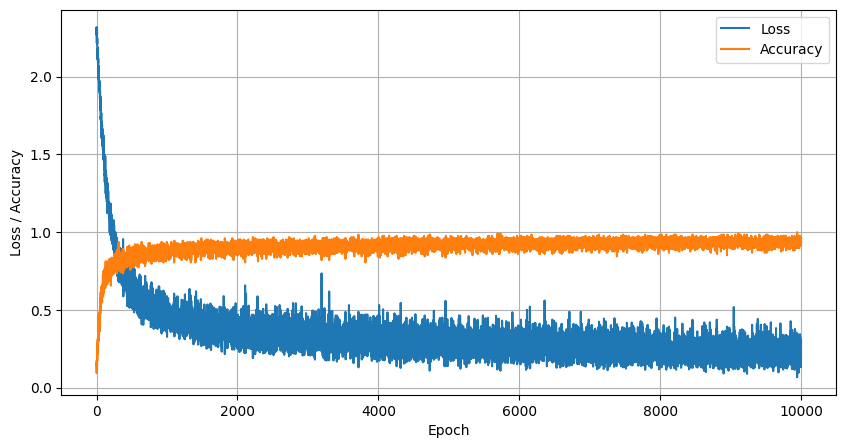

In [3]:

# Initialisiere das Modell
class Model:
    def __init__(self, input_size, hidden_size, output_size):
        # Gewichtsmatrizen initialisieren
        self.w1 = self.layer_init(input_size, hidden_size)
        self.w2 = self.layer_init(hidden_size, output_size)
        
        # Biases als Nullwerte initialisieren
        self.b1 = np.zeros((1, hidden_size), dtype=np.float32)
        self.b2 = np.zeros((1, output_size), dtype=np.float32)

    def layer_init(self, m, h):
        # He-Initialisierung für ReLU-Aktivierungen
        return np.random.randn(m, h) * np.sqrt(2. / m)

    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def softmax(x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, x):
        # Forward Pass durch die Schichten
        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        output = self.softmax(self.z2)
        return output

    def backward(self, x, y, output, learning_rate=0.001):
        # Anzahl der Trainingsbeispiele
        m = y.shape[0]
        
        # Berechne Gradienten für die zweite Schicht
        dz2 = output - y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Berechne Gradienten für die erste Schicht
        dz1 = np.dot(dz2, self.w2.T) * (self.z1 > 0)  # ReLU-Ableitung
        dW1 = np.dot(x.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Aktualisiere die Gewichte
        self.w1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.w2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def cross_entropy(self, predictions, targets):
        predictions = np.clip(predictions, 1e-12, 1. - 1e-12)
        return -np.sum(targets * np.log(predictions)) / targets.shape[0]

    def accuracy(self, predictions, labels):
        pred_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(labels, axis=1)
        return np.mean(pred_labels == true_labels)

# Training und Evaluierung des Modells
def train(model, x_train, y_train, epochs=20000, batch_size=128, learning_rate=0.001):
    losses, accuracies = [], []
    for epoch in (t := trange(epochs)):
        # Zufälliges Sampling für Mini-Batches
        indices = np.random.choice(x_train.shape[0], batch_size)
        batch_x = x_train[indices]
        batch_y = y_train[indices]

        # Forward und Backward Pass
        output = model.forward(batch_x)
        loss = model.cross_entropy(output, batch_y)
        accuracy = model.accuracy(output, batch_y)
        model.backward(batch_x, batch_y, output, learning_rate)
        
        # Speichere den Loss und die Accuracy
        losses.append(loss)
        accuracies.append(accuracy)
        
        # Ausgabe in der Progress-Bar
        t.set_description(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # Plot von Loss und Accuracy über die Epochen
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Loss")
    plt.plot(accuracies, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Beispielhafter Einsatz
# x_train und y_train müssen entsprechend geladen und vorverarbeitet werden
# y_train sollte One-Hot-kodiert sein

# Modellinstanz erstellen
model = Model(input_size=784, hidden_size=128, output_size=10)

# Training starten
nn = train(model, X_train_normalized, Y_train_one_hot, epochs=10000, batch_size=128, learning_rate=0.01)


In [215]:
rnd = np.random.randint(10000)
x_sample = X_test_normalized[rnd]
y_sample = np.argmax(Y_test_one_hot[rnd])
prediction = np.argmax(model.forward(x_sample))
print("Prediction: %d, Y_test_label: %d" % (prediction, y_sample))

Prediction: 2, Y_test_label: 2


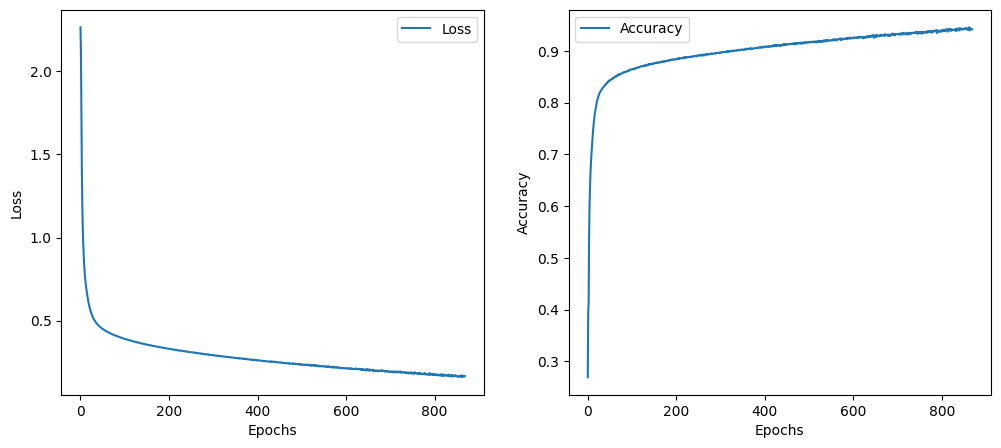

Epoch: 869, Loss: 0.1669, Accuracy: 0.9413:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 869/1000 [57:29<03:20,  1.53s/it]

In [ ]:
import torch 
import matplotlib.pyplot as plt
from tqdm import trange
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from IPython.display import clear_output

# Lade das Dataset ohne One-Hot-Encoding
ds_train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
ds_test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

loader = DataLoader(ds_train, batch_size=500, shuffle=True)

class Model(nn.Module):
    def __init__(self, input, hidden):
        super().__init__()
        self.w1 = nn.Linear(input, hidden)
        self.w2 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.w1(x)
        x = self.relu(x)
        x = self.w2(x)
        x = self.relu(x)
        x = self.out(x)
        return x  # Keine Softmax hier, da CrossEntropyLoss das intern behandelt

my_model = Model(784, 128)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=0.01)
epochs = 1000
losses = []
accuracies = []

for epoch in (t := trange(epochs)):
    epoch_loss = 0  # Durchschnittlicher Loss für die Epoche
    correct = 0
    total = 0
    
    for images, labels in loader:
        images = images.view(-1, 28*28)  # Bilddaten flach machen
        
        predictions = my_model(images)
        loss = loss_fn(predictions, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Sammeln des Verlusts für die Visualisierung
        epoch_loss += loss.item()
        
        # Berechne die Accuracy
        _, predicted = torch.max(predictions, 1)  # Index der höchsten Logit-Wahrscheinlichkeit
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Durchschnittlichen Epoche-Loss und -Accuracy speichern
    losses.append(epoch_loss / len(loader))
    accuracies.append(correct / total)
    
    # Fortschritt anzeigen und Loss sowie Accuracy plotten
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(losses, label="Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(accuracies, label="Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
    plt.show()
    
    t.set_description(f"Epoch: {epoch+1}, Loss: {losses[-1]:.4f}, Accuracy: {accuracies[-1]:.4f}")



In [1]:
print(torch.randint())


NameError: name 'torch' is not defined